In [1]:
import pandas as pd
import numpy as np

import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

import sys

import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display


from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

from IPython.display import Audio

from utils.audio_preprocess import *
from utils.SepTr import *
from utils.feature_exctraction import *

In [6]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

#import warnings
#if not sys.warnoptions:
#    warnings.simplefilter("ignore")
#warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [11]:
# quante mad***e
from scikeras.wrappers import KerasClassifier

In [12]:
Crema = "CREMA-D/AudioWAV/"
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:

    file_path.append(Crema + file)

    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe 
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe Emotions/Path
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df['Emotions'] = pd.Categorical(Crema_df['Emotions'])
Crema_df.head()

,Emotions,Path
0,angry,CREMA-D/AudioWAV/1022_ITS_ANG_XX.wav
1,angry,CREMA-D/AudioWAV/1037_ITS_ANG_XX.wav
2,neutral,CREMA-D/AudioWAV/1060_ITS_NEU_XX.wav
3,neutral,CREMA-D/AudioWAV/1075_ITS_NEU_XX.wav
4,disgust,CREMA-D/AudioWAV/1073_IOM_DIS_XX.wav


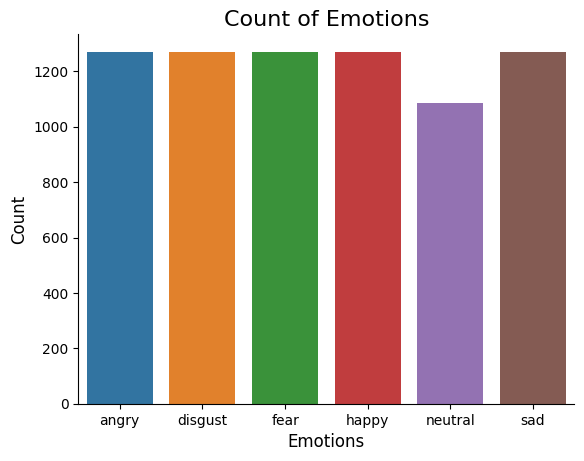

In [13]:
# Plot the count of Emotions
plt.title('Count of Emotions', size=16)
sns.countplot(data=Crema_df, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [14]:
Crema_df.shape

(7442, 2)

### Data Augmentation

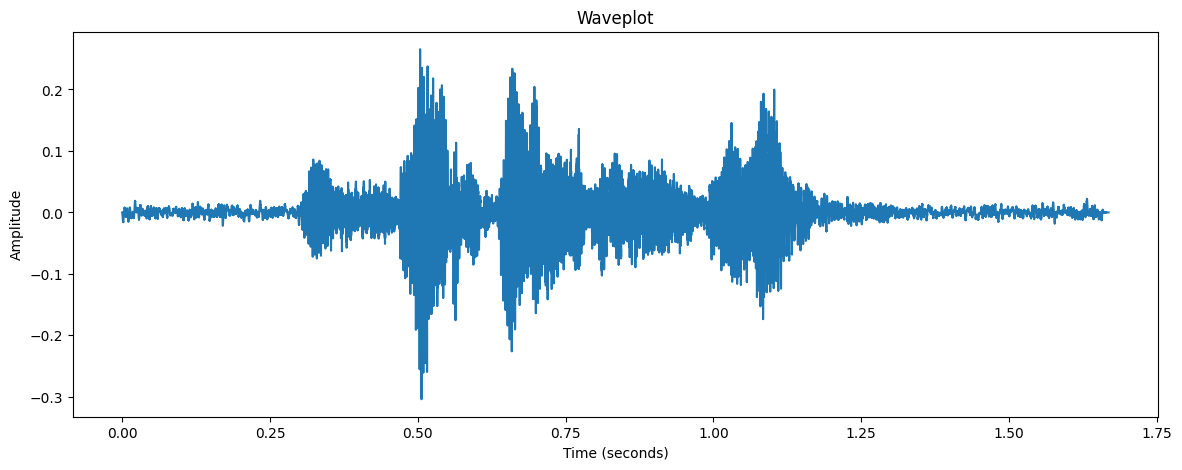

In [15]:
path = np.array(Crema_df.Path[Crema_df.Emotions=='fear'])[1]
data, sampling_rate = librosa.load(path)

duration = len(data) / sampling_rate
time = np.linspace(0, duration, len(data))

plt.figure(figsize=(14, 5))
plt.plot(time, data)
plt.title('Waveplot')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()
Audio(data, rate=sampling_rate)

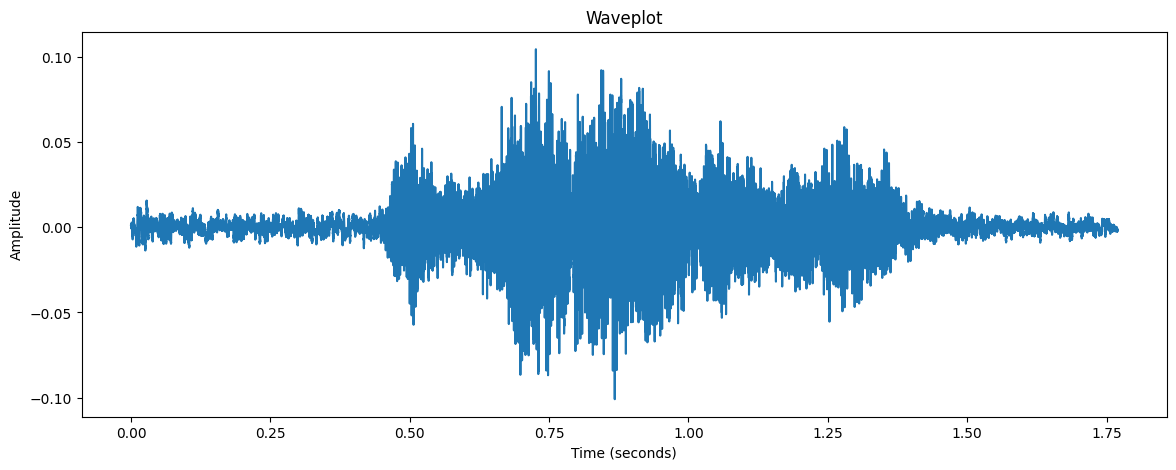

In [16]:
random_audio = random_augmentation(data, sampling_rate)

# Calculate time values
duration = len(random_audio) / sampling_rate
time = np.linspace(0, duration, len(random_audio))

# Create waveplot
plt.figure(figsize=(14, 5))
plt.plot(time, random_audio)
plt.title('Waveplot')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()
Audio(random_audio, rate=sampling_rate)

### Feature Extraction

In [6]:
train, test = train_test_split(Crema_df, random_state=42, shuffle=True)

In [ ]:
x_train, y_train = [], []
x_test, y_test = [], []

# TRAIN + Augmentation
for path, emotion in zip(train.Path, train.Emotions):
    feature = get_features(path, n_iter = 2)
    for ele in feature:
        x_train.append(ele)
        y_train.append(emotion)
Train = pd.DataFrame(x_train)
Train['labels'] = y_train
Train.to_csv('Data/train_synthless.csv', index=False)
Train.head()

# TEST
for path, emotion in zip(test.Path, test.Emotions):
    feature = get_features(path, synth = False)
    for ele in feature:
        x_test.append(ele)
        y_test.append(emotion)
Test = pd.DataFrame(x_test)
Test['labels'] = y_test
Test.to_csv('Data/test_synthless.csv', index=False)
Test.head()

In [13]:
# info
len(x_train), len(y_train), len(x_test), len(y_test), Crema_df.Path.shape

(22324, 22324, 1861, 1861, (7442,))

In [17]:
#Train = pd.read_csv('Data/train_synthless.csv')
#Test = pd.read_csv('Data/test_synthless.csv')

In [18]:
x_train = Train.iloc[: ,:-1].values
y_train = Train['labels'].values

x_test = Test.iloc[: ,:-1].values
y_test = Test['labels'].values

# one hot encoding
encoder = OneHotEncoder()

y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()

y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [20]:
# splitting data
#x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, shuffle=True)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [21]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((22324, 314), (22324, 6), (1861, 314), (1861, 6))

In [26]:
def create_model(filters, kernel_size, strides, pool_size):
    model=Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.1))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units=6, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    #rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.30, verbose=0, patience=2, min_lr=0.0000001)

    #model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test), callbacks=[rlrp])    
    
    #model.summary()

    return model


In [34]:
model = KerasClassifier(build_fn=create_model, verbose=0, batch_size=32)

In [33]:
param_grid = {
    'filter': [256, 128, 64, 32],
    'kernel_size': [3, 5],
    'strides': [1, 3],
    'pool_size': [3, 5, 8],
    'optimizer': ['adam']
}


# Grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print
print("Best hyperparameter: ", grid_result.best_params_)
print("Best accuracy: ", grid_result.best_score_)

best_model = grid_result.best_estimator_
val_accuracy = best_model.score(x_test, y_test)
print("Validaton accuracy: ", val_accuracy)

ValueError: Invalid parameter pool_size for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(pool_size=3)`
Check the list of available parameters with `estimator.get_params().keys()`

In [53]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.30, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=32, epochs=25, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/25


ValueError: in user code:

    File "/Users/robertostaino/Desktop/Università/SER/.venv3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/robertostaino/Desktop/Università/SER/.venv3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/robertostaino/Desktop/Università/SER/.venv3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/robertostaino/Desktop/Università/SER/.venv3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/robertostaino/Desktop/Università/SER/.venv3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/Users/robertostaino/Desktop/Università/SER/.venv3.11/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/robertostaino/Desktop/Università/SER/.venv3.11/lib/python3.11/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/robertostaino/Desktop/Università/SER/.venv3.11/lib/python3.11/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/robertostaino/Desktop/Università/SER/.venv3.11/lib/python3.11/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/robertostaino/Desktop/Università/SER/.venv3.11/lib/python3.11/site-packages/keras/src/backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 6) are incompatible


### SepTr

In [7]:
# Determine batch_size and sequence_length
batch_size = 100 #Crema_df.shape[0]
sequence_lengths = []

# Loop over audio files to compute sequence lengths
for file_path in Crema_df.Path.head(100):
    audio, _ = librosa.load(file_path)  # Load audio file
    sequence_lengths.append(len(audio))

# Determine the maximum sequence length
max_sequence_length = max(sequence_lengths)
# Create a list to hold the input spectrograms
input_dim = 128  # Dimension of input spectrogram
input_spectrograms = []

# Loop over audio files again to compute and store spectrograms
for file_path in Crema_df.Path.head(100):
    audio, _ = librosa.load(file_path)  # Load audio file
    spectrogram = librosa.feature.melspectrogram(y=audio)  # Compute spectrogram
    spectrogram = librosa.power_to_db(spectrogram)  # Convert to dB scale
    spectrogram = torch.tensor(spectrogram.T)  # Transpose and convert to tensor
    input_spectrograms.append(spectrogram)

# Determine the new batch size and adjust the tensor size
batch_size = len(input_spectrograms)
input_spectrograms_resized = torch.zeros(batch_size, max_sequence_length, input_dim)
for i, spectrogram in enumerate(input_spectrograms):
    length = min(max_sequence_length, spectrogram.size(0))
    input_spectrograms_resized[i, :length, :] = spectrogram[:length, :]



In [49]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder on the word array and transform the words into integers
y_train = label_encoder.fit_transform(y_train)

y_test = label_encoder.fit_transform(y_test)

In [47]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Estrazione delle features e dei target dal DataFrame
features = x_train
target = integer_array

# Trasformazione in tensori PyTorch
features_tensor = torch.tensor(features, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.int8)

# Creazione del dataset
dataset = TensorDataset(features_tensor, target_tensor)

# Creazione del dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [48]:
import torch.optim as optim

num_classes = 6  # Numero di classi di output

model = AudioCNN(num_classes)

# Definizione della funzione di perdita e dell'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Addestramento del modello
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass e ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

torch.Size([1, 314])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x37 and 3840x256)

In [ ]:
input_dim = 128  # Dimension of input spectrogram
hidden_dim = 256  # Dimension of hidden layers
num_heads = 4  # Number of attention heads
num_layers = 6  # Number of SepTr encoder layers

model = SepTr(input_dim, hidden_dim, num_heads, num_layers)
output = model(input_spectrograms_resized)

### Melspectrogram

In [18]:
mel = librosa.feature.melspectrogram(y=data, sr=22050)
mel_spec_db = librosa.power_to_db(mel)
print(mel.shape)
print(mel_spec_db.shape)

(128, 72)
(128, 72)


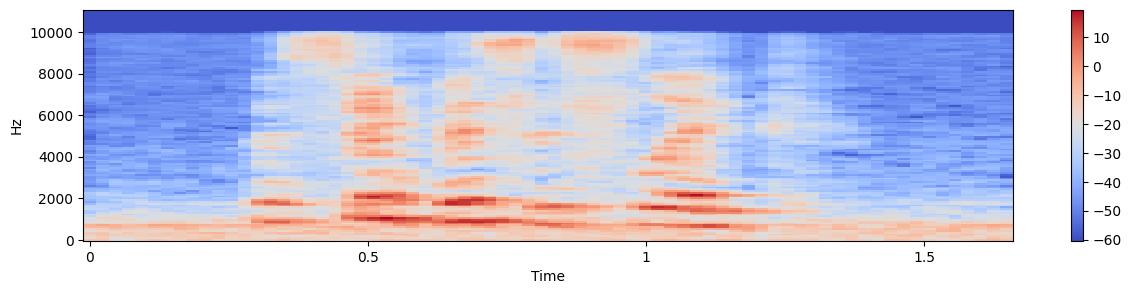

In [19]:
plt.figure(figsize=(15, 3))
librosa.display.specshow(mel_spec_db, sr=22050, x_axis='time', y_axis='hz')
plt.colorbar()

### Chromagram

In [20]:
stft = np.abs(librosa.stft(data))
chroma_stft = librosa.feature.chroma_stft(S=stft, sr=22050)

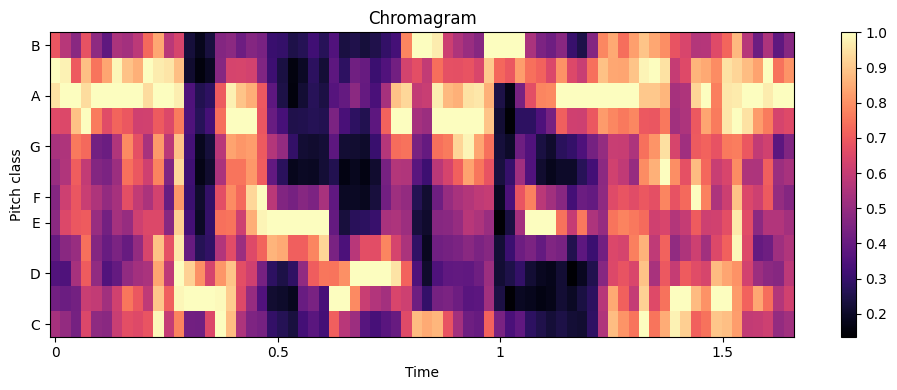

In [21]:
# Plot the chroma feature
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()

In [22]:
chroma_stft.shape

(12, 72)